In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score
from src.denoise_utils import denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style, VGG, VGG_dropout, VGG_noise
from src.datasets import StyleDataset, ArtistDataset
from src.train import train
from src.metric_utils import fid_metric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from collections import deque
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**FID**
- Comparison of max diversity and query set of samples
- Get distribution of FID vectors for each set + fit gaussian
- Frechet distance between gaussians

In [3]:
for exp_file in glob('data/final/cave/*/'):
    exp = os.path.basename(os.path.dirname(exp_file))
    if exp!='max_div':
        print(exp)
        print(fid_metric(exp))


max_div2
{'stats': 3.1619584465502157, 'local': 0.8060364672148523, 'gram64': 0.6090713574376423}
min_div
{'stats': 71.37755367342379, 'local': 8.685041981553198, 'gram64': 856.9077024221001}
averagedim_all_r10
{'stats': 71.02356331322824, 'local': 8.456937079276585, 'gram64': 814.0823104446572}
vggro3_all_r1000
{'stats': 68.17141354830105, 'local': 8.22528265592807, 'gram64': 859.7519633016946}
averagedim_all_r100
{'stats': 71.06855635677621, 'local': 8.59384055091813, 'gram64': 849.0034720353087}
ro3_all_r500
{'stats': 65.50791897882073, 'local': 7.894506363638868, 'gram64': 882.1449313092112}
cnn16_all_r500
{'stats': 71.79875445650177, 'local': 8.764678782291028, 'gram64': 798.5773165609694}
vgg_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
{'stats': 65.97050385508012, 'local': 7.7618890958351585, 'gram64': 745.340456734702}
vgg_dc_channel_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
{'stats': 64.42709019429765, 'local': 7.99611041147

In [10]:
# Read image sets
# f = []
# for file in glob(f"data/final/cave/{exp}/*/*.png"):
#     f.append(file)
f = []
for file in glob(f"data/final/tree/max_div/Leonid_Afremov/*.png"):
    f.append(file)

In [42]:
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 2048  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None)

# save_statistics(f"data/final/cave/{exp}_stats.npz",m,s)

Starting to sample.


In [43]:
m0, s0 = load_statistics("data/final/cave/max_div_stats.npz")
m, s = load_statistics(f"data/final/cave/{exp}_stats.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

65.50791897882073

Localisation diversity

In [15]:
## activations
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 192  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None)
# act = np.mean(act,axis=1)
# act = act.reshape(act.shape[0], -1)
# mu = np.mean(act, axis=0)
# sigma = np.cov(act, rowvar=False)
# save_statistics(f'data/final/cave/{exp}_local.npz',mu,sigma)


Starting to sample.


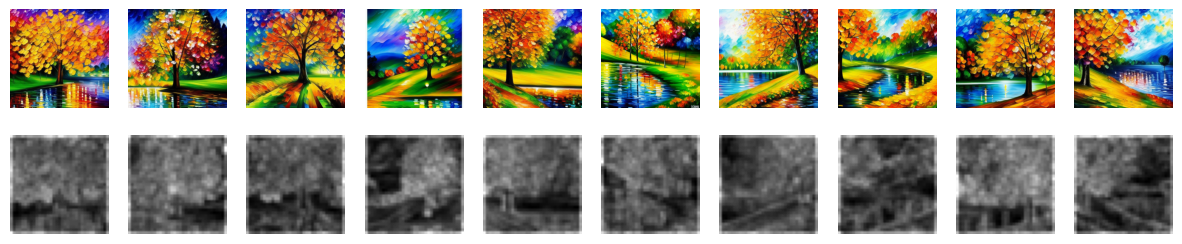

In [16]:
mean_act = np.mean(act,axis=1)
n=10
plt.figure(figsize=(15,3))
for i in range(n):
    img = Image.open(f[50+i])
    plt.subplot(2,n,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2,n,n + i + 1)
    plt.imshow(mean_act[50+i], cmap='gray')
    plt.axis('off')
# plt.savefig("figures/inceptionfeatures.pdf")

In [46]:
# Get FID of each artist's images
for f in glob("data/styles/artists/*"):
    imgs = []
    for imgf in glob(f"{f}/*.png"):
        imgs.append(imgf)
    print(len(imgs))
    m, s = calculate_activation_statistics(imgs, model, 8, dims, device)
    save_statistics(f"{f}/fid.npz",m,s)

In [47]:
m0, s0 = load_statistics("data/final/cave/max_div_local.npz")
m, s = load_statistics(f"data/final/cave/{exp}_local.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

7.894506363638868

Style diversity


In [48]:
## activations
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 64  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None, gap=True)
gram = np.einsum('ni,nj->nij',act,act)
# Flattened upper triangular 
sims = []
for i in range(len(gram)):
    sim = gram[i][np.triu_indices(dims)]
    sims.append(sim)
sims = np.stack(sims)
mu = np.mean(sims, axis=0)
sigma = np.cov(sims, rowvar=False)
save_statistics(f'data/final/cave/{exp}_gram64.npz',mu,sigma)

Starting to sample.


In [49]:
m0, s0 = load_statistics("data/final/cave/max_div_gram64.npz")
m, s = load_statistics(f"data/final/cave/{exp}_gram64.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

882.1449313092112

In [50]:
# Plot images from dataset
import glob
n=2
images = []
for folder in glob.glob("data/fruit/*"):
    i=0
    for file in glob.glob(os.path.join(folder,"*")):
        if i<n:
            images.append(Image.open(file))
            i+=1

grid = image_grid(images, rows=n, cols=10)



t-SNE